# Stock Dashboard

Simple example of fetching NASDAQ stock data and showing it in a dashboard.  Make sure that jupyter-dashboards is installed and enabled (e.g. ``conda install -c conda-force jupyter-dashboard`` and follow printed instructions), then run the notebook and select the "Dashboard View" (either a speedometer symbol in the toolbar, or menu item View/Dashboard Preview).  The result should be a live interactive dashboard looking something like this [screenshot](https://github.com/ioam/paramnb/raw/master/doc/images/stock_dashboard.png).  Requires the latest github master for [holoviews](https://github.com/ioam/holoviews) (at least until the holoviews 1.7 release), and possibly also for datashader.

In [1]:
import param
import paramnb

import pandas as pd
import holoviews as hv
import dask.dataframe as dd

from bokeh.io import output_notebook
from dask.delayed import delayed
from pandas_datareader.yahoo import daily

output_notebook(hide_banner=True)
hv.notebook_extension('bokeh', width=90)

Load all current NASDAQ stock symbols (from ftp://ftp.nasdaqtrader.com/SymbolDirectory/nasdaqlisted.txt).

In [2]:
symbols = pd.read_csv('~/nasdaqlisted.txt', sep='|')

Download daily NASDAQ stocks for 2015-2016 into a dataframe that we can plot, using dask to handle simultaneous requests.

In [3]:
def get_symbol(sym, start='2015-01-01', end='2016-12-01'):
    try:
        df = daily.YahooDailyReader(sym, start=start, end=end).read().reset_index()
        df['Symbol'] = sym
        return df
    except:
        return pd.DataFrame()

import logging
logging.getLogger('requests').setLevel(logging.CRITICAL)
stocks = [delayed(get_symbol)(sym) for sym in symbols.Symbol]
df = dd.from_delayed(stocks).compute()

In [4]:
df['Timestamp'] = df.Date.astype('int64')
dataset = hv.Dataset(df)
top_stocks = df.groupby('Symbol').Volume.sum().sort_values(ascending=False).index[0:500]

Set up interactive plotting of user-selectable stock symbols with a selectable amount of rolling_window smoothing.

In [5]:
class StockSelector(hv.streams.Stream):
    
    symbols = param.ListSelector(default=list(top_stocks)[0:5], objects=list(top_stocks))
    
    rolling_window = param.Integer(default=3, bounds=(1, 20))

    def get_curves(self, **kwargs):
        selected = dataset.select(Symbol=list(self.symbols))
        df = selected.data.set_index('Date').groupby('Symbol').rolling(window=self.rolling_window, center=True).mean()
        curves = hv.Dataset(df.reset_index('Date')).to(hv.Curve, 'Date', 'Close', ['Symbol'])
        return curves.overlay()

selector = StockSelector(name="")
selector

StockSelector(rolling_window=3,symbols=['AAPL', 'SIRI', 'MSFT', 'QQQ', 'MU'])

## Stock Explorer

Select one or more stocks to show, along with the desired amount of smoothing.

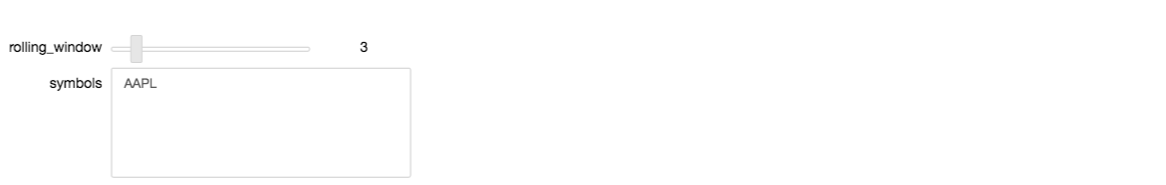

In [6]:
paramnb.Widgets(selector, callback=selector.update)

In [7]:
%%opts NdOverlay [width=800 height=400 legend_limit=0 tools=['hover']] Curve (color=Palette('Set1'))
hv.DynamicMap(selector.get_curves, kdims=[], streams=[selector])

:DynamicMap   []